<a href="https://colab.research.google.com/github/Diegomjx/DDOS_DETECTOR/blob/master/DDOS_Detector_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DDOS Detector Version 2 with another DATASETS


Epoch 1/100
117/117 - 4s - 33ms/step - accuracy: 0.4851 - loss: 2.6522 - val_accuracy: 0.6345 - val_loss: 2.0969
Epoch 2/100
117/117 - 1s - 6ms/step - accuracy: 0.7856 - loss: 1.7306 - val_accuracy: 0.9293 - val_loss: 1.4155
Epoch 3/100
117/117 - 1s - 10ms/step - accuracy: 0.9616 - loss: 1.2053 - val_accuracy: 0.9820 - val_loss: 1.0239
Epoch 4/100
117/117 - 1s - 8ms/step - accuracy: 0.9931 - loss: 0.9041 - val_accuracy: 0.9989 - val_loss: 0.8006
Epoch 5/100
117/117 - 1s - 6ms/step - accuracy: 0.9997 - loss: 0.7308 - val_accuracy: 1.0000 - val_loss: 0.6643
Epoch 6/100
117/117 - 1s - 7ms/step - accuracy: 1.0000 - loss: 0.6088 - val_accuracy: 1.0000 - val_loss: 0.5596
Epoch 7/100
117/117 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.5313 - val_accuracy: 1.0000 - val_loss: 0.5096
Epoch 8/100
117/117 - 1s - 5ms/step - accuracy: 1.0000 - loss: 0.4988 - val_accuracy: 1.0000 - val_loss: 0.4902
Epoch 9/100
117/117 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.4861 - val_accuracy: 1.0000 - val_los

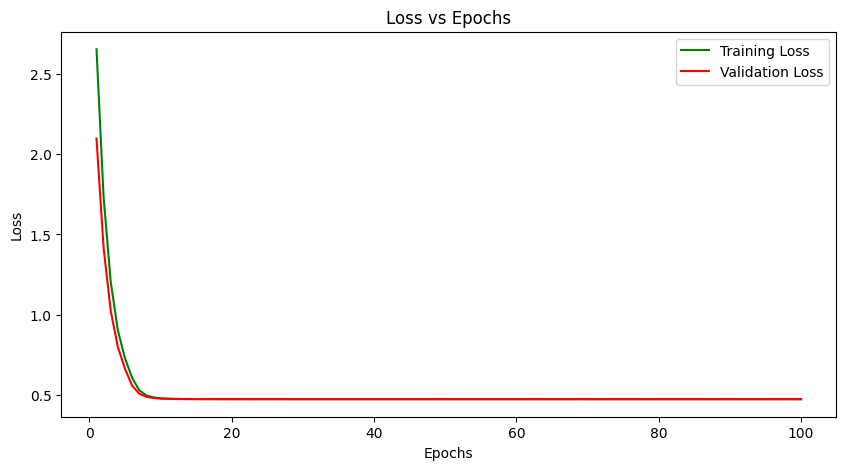

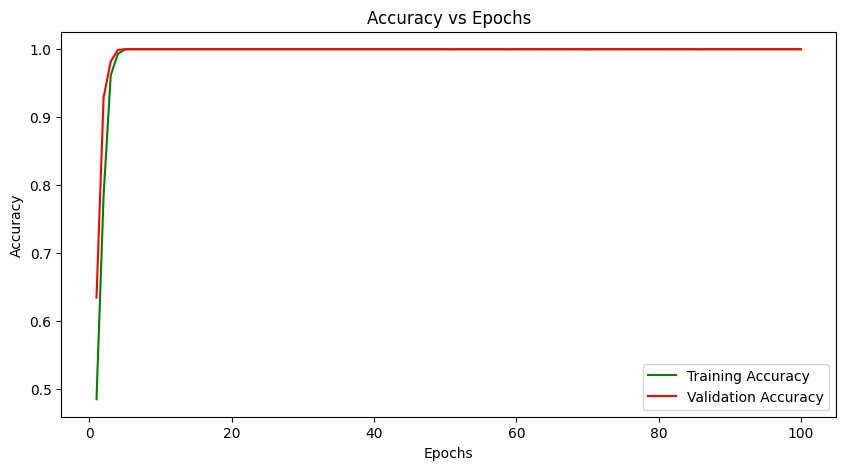

473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


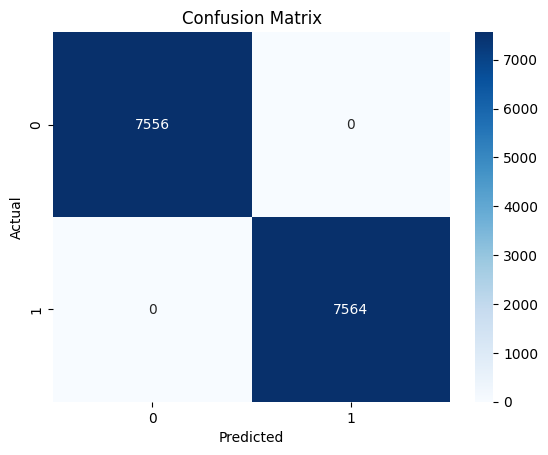

473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


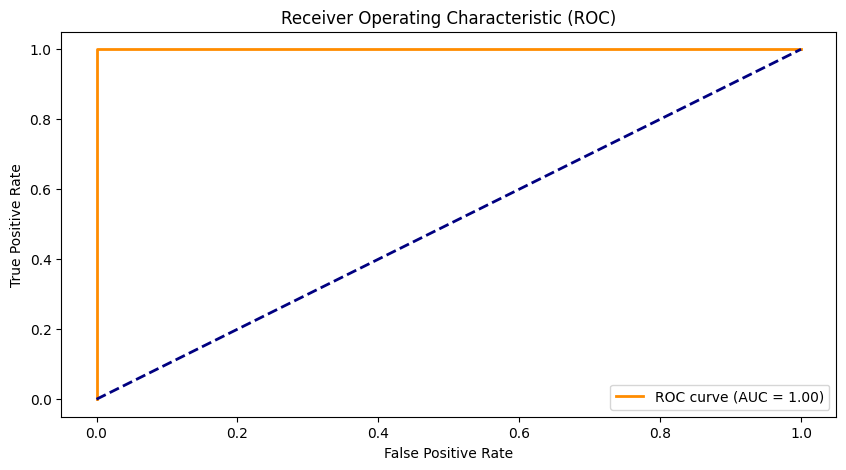

In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
import re

# 1. Load and clean data
df = pd.read_csv("APA-DDoS-Dataset.csv")

# Drop constant features
constant_features = df.columns[df.nunique() == 1]
df.drop(constant_features, axis=1, inplace=True)

# Normalize frame.time
df['frame.time'] = df['frame.time'].str.replace(' Mountain Daylight Time', '').str.strip()
df['frame.time'] = df['frame.time'].apply(lambda x: re.sub(r'\..*', '', x))
df['frame.time'] = pd.to_datetime(df['frame.time'], format='%d-%b %Y %H:%M:%S')
df['frame.time'] = df['frame.time'].dt.tz_localize('UTC').dt.tz_convert('US/Mountain')

# Drop unused features
df.drop(['Tx Bytes', 'Rx Bytes'], axis=1, inplace=True)

# Normalize numerical features
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
def z_score_normalization(x):
    return (x - x.mean()) / x.std()
df[numerical_features] = df[numerical_features].apply(z_score_normalization)

# Encode categorical features
label_encoder = LabelEncoder()
df['ip.src'] = label_encoder.fit_transform(df['ip.src'])

# Map and encode labels
label_mapping = {'Benign': 0, 'DDoS-PSH-ACK': 1, 'DDoS-ACK': 1}
df['label_encoded'] = df['Label'].map(label_mapping)
df.drop(['Label'], axis=1, inplace=True)

# 2. Split the dataset
y = df['label_encoded']
X = df.drop(columns=['label_encoded'])
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Compute class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 3. Build the model

# Callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model=Sequential([
    Input(shape=(10,)),
    Dense(units=5,activation='relu',name='Hidden_layer_1',kernel_regularizer=L2(0.3)),
    #Dense(units=2,activation='relu',name='Hidden_layer_2',kernel_regularizer=L2(0.3)),
    Dense(units=1,activation='sigmoid',name='Output_layer',kernel_regularizer=L2(0.1))
])
model.compile(optimizer=Adam(learning_rate=1e-3),loss=BinaryCrossentropy(),metrics=['accuracy'])

# 4. Train the model

history_log = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=100, verbose=2,
    callbacks=None,
    shuffle=True,
    validation_data=(X_val,y_val),
    class_weight=None,
    sample_weight=None,
    initial_epoch=0)
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', 'Precision', 'Recall'])


# 5. Evaluate the model
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")

# 6. Visualize training and validation metrics
epochs = range(1, len(history_log.history['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, history_log.history['loss'], 'g', label='Training Loss')
plt.plot(epochs, history_log.history['val_loss'], 'r', label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, history_log.history['accuracy'], 'g', label='Training Accuracy')
plt.plot(epochs, history_log.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 7. Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 8. ROC Curve
y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 151200 entries, 0 to 151199
Series name: label_encoded
Non-Null Count   Dtype
--------------   -----
151200 non-null  int64
dtypes: int64(1)
memory usage: 1.2 MB


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151200 entries, 0 to 151199
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ip.src          151200 non-null  int64  
 1   tcp.srcport     151200 non-null  float64
 2   frame.len       151200 non-null  float64
 3   tcp.flags.push  151200 non-null  float64
 4   ip.flags.df     151200 non-null  float64
 5   frame.time      151200 non-null  float64
 6   Packets         151200 non-null  float64
 7   Bytes           151200 non-null  float64
 8   Tx Packets      151200 non-null  float64
 9   Rx Packets      151200 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 11.5 MB


Dataset: https://www.kaggle.com/datasets/yashwanthkumbam/apaddos-dataset/data